In [ ]:
 pip install pandas seaborn xgboost shap fairlearn scikit-learn matplotlib


In [ ]:
import pandas as pd
import seaborn as sns

data = sns.load_dataset('titanic')

In [ ]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


In [ ]:
data = data[["survived","pclass","sex","age","sibsp","parch","fare","embarked"]].dropna()

In [ ]:
data["userid"] = pd.util.hash_pandas_object(data).astype(str)

In [ ]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,userid
0,0,3,NaN,22.0,1,0,7.2500,0,4875039442227335780
1,1,1,NaN,38.0,1,0,71.2833,1,12717287665686313995
2,1,3,NaN,26.0,0,0,7.9250,0,5814593412311810652
3,1,1,NaN,35.0,1,0,53.1000,0,13040156107180985591
4,0,3,NaN,35.0,0,0,8.0500,0,18205792772914191508


In [ ]:
# encode categorical data

data["sex"] = data["sex"].map({"male":0,"female":1})
data["embarked"] = data["embarked"].map({"S":0,"C":1,"Q":2})


In [ ]:
# Drop sensitive (even hashed) identifiers from modeling
data = data.drop(columns=['userid'])

In [ ]:
# split train test data
X = data.drop(["survived"],axis=1)
y=data["survived"]

In [ ]:
# training
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
model = XGBClassifier(use_label_encoder=True,eval_metric='logloss')
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.7552447552447552


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:54:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Fairness and evaluation

# Gender column in test data
sensitive_feature = X_test['sex']

In [ ]:
sensitive_feature

,sex
641,1
496,1
262,0
311,1
551,0
...,...
362,1
56,1
137,0
651,1


In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate

In [ ]:
fair_matrics = MetricFrame(
   metrics={ "accuracy":accuracy_score,
    "selection_rate" :selection_rate},
    y_true=y_test,
    y_pred = y_pred,
    sensitive_features=sensitive_feature
)

print(fair_matrics.by_group)

     accuracy  selection_rate
sex                          
0    0.728261        0.163043
1    0.803922        0.803922


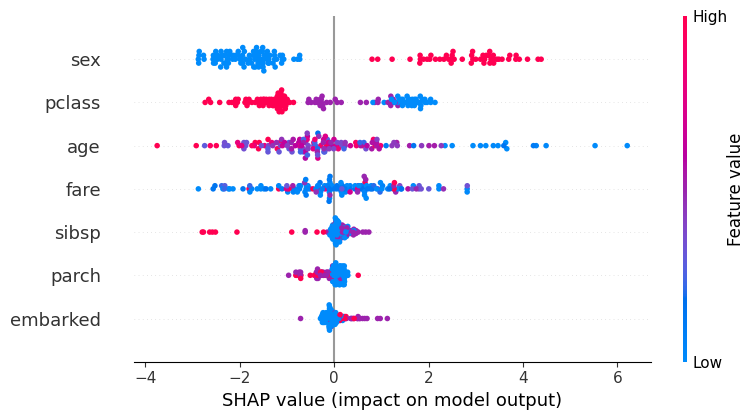

In [ ]:
# Explainability with SHAP
import shap

explainer = shap.Explainer(model,X_train)
shap_values = explainer(X_test)

# global summary
shap.summary_plot(shap_values,X_test)



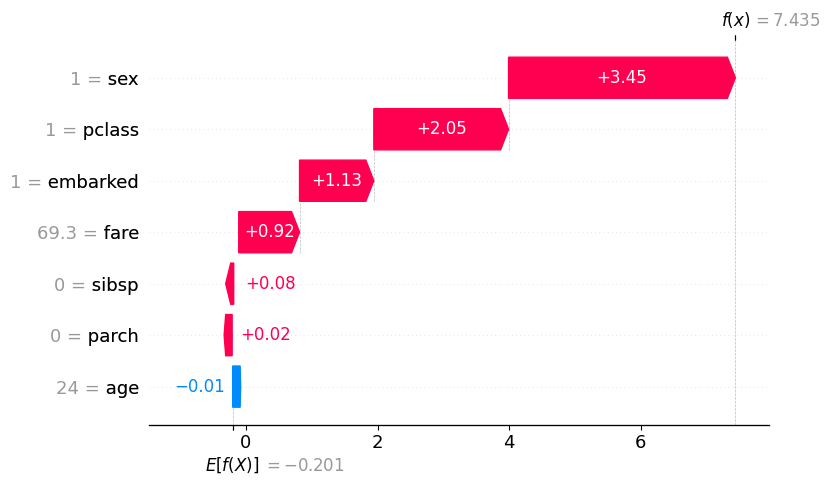

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
# simulated access control
def get_prediction(user_role,data):
  if user_role == 'admin':
    return model.predict(data)
  elif user_role == 'analyst':
    return "Access denied Analysist"
  else:
      return "invalid role"
print(get_prediction('admin',X_test.iloc[:1]))
print(get_prediction('analyst',X_test.iloc[:1]))



[1]
Access denied Analysist


In [ ]:
# symmetric Encryption using Fernet(AES 128-bit)

from cryptography.fernet import Fernet

# generate encryption key
key = Fernet.generate_key()
cipher = Fernet(key)

print("Encryption key",key.decode())
# store this

Encryption key ozoJKnIuEm_KSMTTafvkJ61JXjoYwxABitFG7XiEkcc=


In [ ]:
sensitive_data = "jhon.deo@gmail.com".encode()

# encrypt
encrypted_data = cipher.encrypt(sensitive_data)
print("Encrypted :",encrypted_data)

# decrypt
decrypted_data = cipher.decrypt(encrypted_data)
print("decrypted",decrypted_data.decode())

Encrypted : b'gAAAAABocKwAh-l9-bOfZ6zci4_t4jp9seTxWkBzN7Io1fkuu5erk0k5pgk_8yqiqpWO7fApZcJpOmHWQ7nwCzGy672gb59AJ2xkwQ-NlBuhC9XEKgw8bMU='
decrypted jhon.deo@gmail.com
